# Synthetic Data Evaluation

Notebook ini mengevaluasi kualitas data sintetis sesuai dokumen `notes/eval_synth_data.md`.
Metrik yang dihitung: **KS Mean**, **Correlation Gap**, **Duplicate Rate**, dan **TSTR**.


In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the project root directory (parent of notebooks folder)
project_root = os.path.dirname(os.getcwd())
sys.path.insert(0, project_root)

from loader.data_loader import UniversalDataLoader
from model import oversample_with_pytorch_gan, oversample_with_ctgan, oversample_with_cond_wgangp
import importlib
import evaluation.synth_eval as synth_eval
importlib.reload(synth_eval)
from evaluation.synth_eval import evaluate_synthetic_data, extract_synthetic_tail

sns.set_style('whitegrid')

DATA_PATH = "/Users/rudyhendrawan/Projects/data"
DATASET_NAME = os.environ.get('DATASET_NAME', '03_fraud_oracle.csv')
DATA_ROOT = os.environ.get('DATA_ROOT', DATA_PATH)
RANDOM_STATE = int(os.environ.get('RANDOM_STATE', '42'))
EPOCHS = int(os.environ.get('EPOCHS', '300'))
BATCH_SIZE = int(os.environ.get('BATCH_SIZE', '128'))

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
loader = UniversalDataLoader(
    DATASET_NAME,
    project_root=project_root,
    data_root=DATA_ROOT,
    verbose=False,
    large_data=False,
)
X_train, X_val, X_test, y_train, y_val, y_test, _ = loader.train_val_test_split()
print('Train:', X_train.shape, 'Test:', X_test.shape)

INFO:loader.data_loader:Initialized loader for: Vehicle Claim Fraud
INFO:loader.data_loader:Data path: /Users/rudyhendrawan/Projects/data/03_fraud_oracle.csv
INFO:loader.data_loader:Loaded raw data: 15420 rows, 33 columns
INFO:loader.data_loader:Class distribution: {0: 14497, 1: 923}
INFO:loader.data_loader:Using stratified shuffle split.
INFO:loader.data_loader:
Data split:
INFO:loader.data_loader:. Train: 9252 samples | Class distribution: {0: 0.9401210549070471, 1: 0.05987894509295288}
INFO:loader.data_loader:. Validation: 3084 samples | Class distribution: {0: 0.9400129701686122, 1: 0.05998702983138781}
INFO:loader.data_loader:. Test: 3084 samples | Class distribution: {0: 0.940337224383917, 1: 0.05966277561608301}


Train: (9252, 32) Test: (3084, 32)


In [2]:
results = []

# PyTorch GAN
X_gan, y_gan, *_ = oversample_with_pytorch_gan(
    X_train, y_train, target_class=1, oversample_ratio=1.0, epochs=EPOCHS, batch_size=BATCH_SIZE
)
syn_X, syn_y = extract_synthetic_tail(X_train, X_gan, y_train, y_gan)
if syn_X is not None:
    metrics = evaluate_synthetic_data(X_train, syn_X, X_test, y_test, syn_y, y_real=y_train, seed=RANDOM_STATE)
    metrics['method'] = 'PyTorch_GAN'
    results.append(metrics)

# CTGAN
X_ctgan, y_ctgan, *_ = oversample_with_ctgan(
    X_train, y_train, target_class=1, oversample_ratio=1.0, epochs=EPOCHS, batch_size=BATCH_SIZE
)
syn_X, syn_y = extract_synthetic_tail(X_train, X_ctgan, y_train, y_ctgan)
if syn_X is not None:
    metrics = evaluate_synthetic_data(X_train, syn_X, X_test, y_test, syn_y, y_real=y_train, seed=RANDOM_STATE)
    metrics['method'] = 'CTGAN'
    results.append(metrics)

# Conditional WGAN-GP
X_cwgan, y_cwgan, *_ = oversample_with_cond_wgangp(
    X_train, y_train, target_class=1, target_ratio=1.0, epochs=EPOCHS, batch_size=BATCH_SIZE
)
syn_X, syn_y = extract_synthetic_tail(X_train, X_cwgan, y_train, y_cwgan)
if syn_X is not None:
    metrics = evaluate_synthetic_data(X_train, syn_X, X_test, y_test, syn_y, y_real=y_train, seed=RANDOM_STATE)
    metrics['method'] = 'Conditional_WGAN_GP'
    results.append(metrics)

synth_df = pd.DataFrame(results)
synth_df

Original class distribution:
Majority class (0): 8698 samples
Minority class (1): 554 samples
Using device: mps
Training PyTorch GAN for 300 epochs...
Epoch [100/300], Gen Loss: 0.6911, Disc Loss: 1.3983
Epoch [200/300], Gen Loss: 0.7272, Disc Loss: 1.3557
Epoch [300/300], Gen Loss: 0.7007, Disc Loss: 1.3833
Generating 8144 synthetic samples...

Final class distribution after Pytorch GAN oversampling:
Majority class (0): 8698 samples
Minority class (1): 8698 samples
Original class distribution:
Majority class (0): 8698 samples
Minority class (1): 554 samples
Using device: mps
Training Simplified CTGAN for 300 epochs...
Epoch [100/300], Gen Loss: -1.1796, Disc Loss: -2.5859
Epoch [200/300], Gen Loss: 0.1569, Disc Loss: -2.3249
Epoch [300/300], Gen Loss: 0.3336, Disc Loss: -0.8879
Generating 8144 synthetic samples...

Final class distribution after CTGAN oversampling:
Majority class (0): 8698 samples
Minority class (1): 8698 samples
Original class distribution:
Majority class (0): 8698 s

,ks_mean,correlation_gap,duplicate_rate,tstr_pr_auc,tstr_precision,tstr_recall,tstr_f1,tstr_valid,method
0,0.419441,10.858883,0.0,0.069322,0.066667,0.173913,0.096386,1.0,PyTorch_GAN
1,0.466386,12.634902,0.0,0.065760,0.133333,0.021739,0.037383,1.0,CTGAN
2,0.455547,11.294184,0.0,0.099292,0.095460,0.445652,0.157239,1.0,Conditional_WGAN_GP


,ks_mean,correlation_gap,duplicate_rate,tstr_pr_auc,tstr_precision,tstr_recall,tstr_f1,tstr_valid,method
0,0.419441,10.858883,0.0,0.069322,0.066667,0.173913,0.096386,1.0,PyTorch_GAN
1,0.466386,12.634902,0.0,0.065760,0.133333,0.021739,0.037383,1.0,CTGAN
2,0.455547,11.294184,0.0,0.099292,0.095460,0.445652,0.157239,1.0,Conditional_WGAN_GP


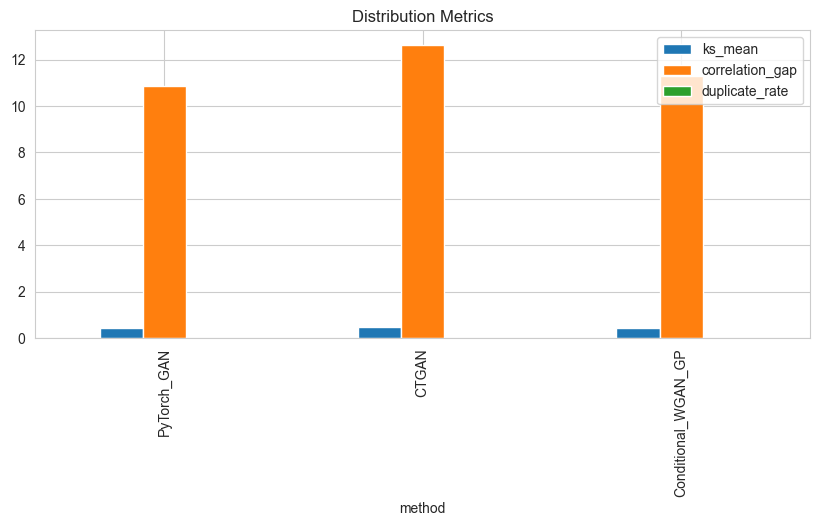

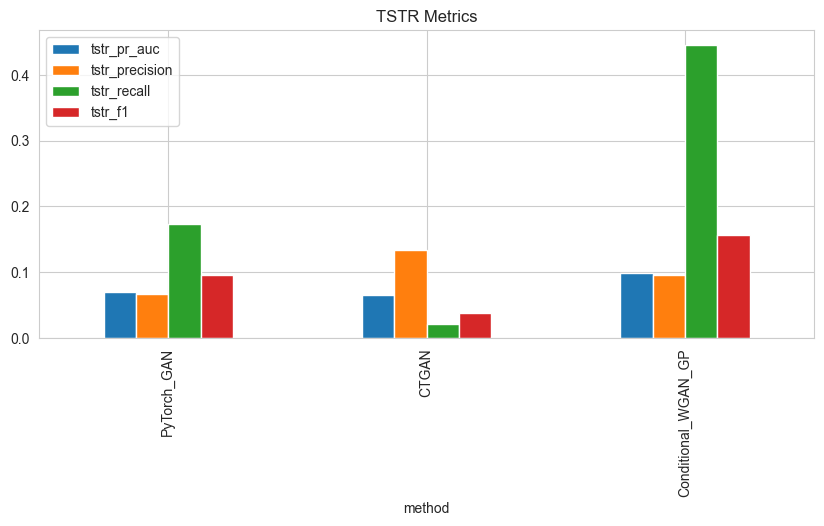

In [3]:
if not synth_df.empty:
    display(synth_df)
    synth_df.set_index('method')[['ks_mean', 'correlation_gap', 'duplicate_rate']].plot(kind='bar', figsize=(10,4))
    plt.title('Distribution Metrics')
    plt.show()

    synth_df.set_index('method')[['tstr_pr_auc', 'tstr_precision', 'tstr_recall', 'tstr_f1']].plot(kind='bar', figsize=(10,4))
    plt.title('TSTR Metrics')
    plt.show()
